# Classificação de acordes

Este trabalho tem como objetivo a proposta e implementação (em Python) de um algoritmo capaz de classificar acordes em gravações de música. O método consiste em análises periódicas do espectro de frequência, associando as frequências a cada uma das 12 notas da escala cromática, gerando um histograma de notas para cada janela de tempo. A partir desse processo de classificação, encontramos possíveis tríades que podem ser formadas pelas notas que compõem o histograma. Qual seria o resutado deste algoritmo? Quão bem ele é capaz de classificar corretamente acordes em músicas gravadas?

## O espectro de frequências e _fast Fourier transform_

Em processamento digital de áudio, a análise no domínio da frequência, principalmente o de amplitude, pode trazer bastante informação sobre o sinal, mais do que a simples análise temporal.

In [1]:
import numpy as np
from scipy import fftpack
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
Fs = 44100
Tmax = 2
A3 = 440.0
E3 = 329.63
t = np.linspace(0, Tmax, Tmax*Fs)
s = 0.7*np.sin(2*np.pi*A3*t) + 0.3*np.sin(2*np.pi*E3*t)
ipd.Audio(s, rate=Fs)

(0.0, 0.025)

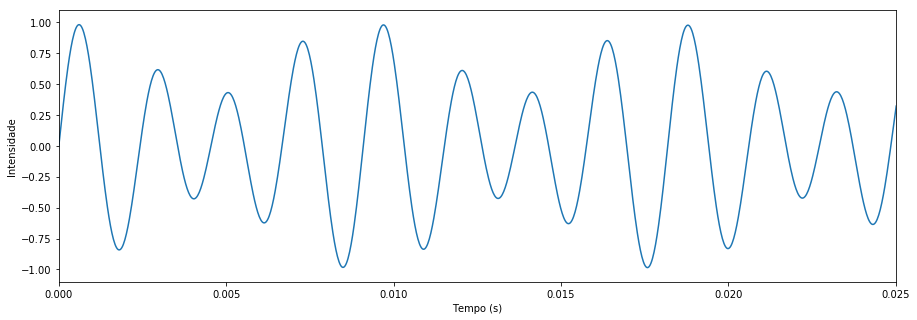

In [3]:
plt.figure(figsize=(15,5))
plt.plot(t, s)
plt.xlabel('Tempo (s)')
plt.ylabel('Intensidade')
plt.xlim(0.0, 0.025)

(300, 500)

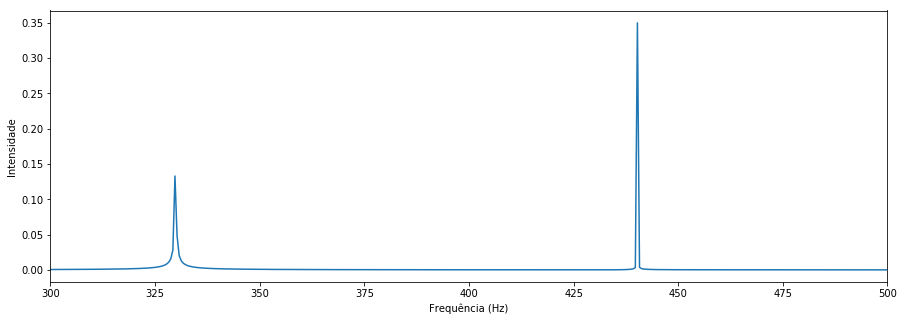

In [4]:
S = fftpack.fft(s)
S = S/len(S)
f = np.linspace(-Fs/2, Fs/2, len(S))
Splot = np.abs(fftpack.fftshift(S))
plt.figure(figsize=(15,5))
plt.plot(f, Splot)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Intensidade')
plt.xlim(300, 500)

## Análise tempo-frequência e _short-time Fourier transform_

É possível dividir as amostras de um sinal de áudio em janelas de tempo, de modo que possamos determinar o espectro periódico do sinal

In [22]:
tchirp = np.linspace(0, 3, 3*Fs)
s = signal.chirp(tchirp, 200.0, 3, 1000.0, 'logarithmic')
ipd.Audio(s, rate=Fs)

(0, 1000)

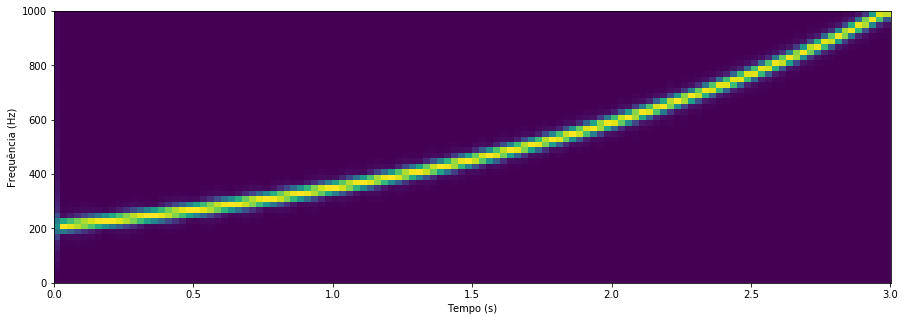

In [24]:
f, t, Stf = signal.stft(s, fs=Fs, nperseg=int(Fs/20))
plt.figure(figsize=(15,5))
Stfplot = np.abs(Stf)
plt.pcolormesh(t, f, Stfplot)
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.ylim(0, 1000)